In [2]:
import sys
import os
os.chdir('../')
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset
from tqdm import tqdm
from omegaconf import OmegaConf
from hydra import compose, initialize
import matplotlib.pyplot as plt

from ablations.models import BayesianMLP
from experiments.utils import get_configs, get_datasets
import random
%load_ext autoreload
%autoreload 2

In [3]:
# Point to your config directory and name
config_dir = "configs/"  # adjust as needed
config_name = "uci_best.yaml"

with initialize(config_path=config_dir, version_base='1.2'):
    args = compose(config_name=config_name)

# cfg is now a DictConfig
print(args)

{'train': {'disagreement_epochs': 5, 'disagreement_optimizer': 'torch.optim.AdamW', 'disagreement_wd': 0.0001, 'disagreement_lr': 0.01, 'disagreement_batch_size': 64, 'disagreement_alpha': 0.8, 'num_epochs': 50, 'batch_size': 64, 'lr': 0.001, 'wd': 0.0001, 'optimizer': 'torch.optim.AdamW', 'clip_val': 1, 'val_freq': 1, 'num_workers': 4, 'pin_memory': True}, 'dataset': {'name': 'uci', 'num_classes': 2, 'data_dir': 'data/uci_data', 'normalize': True}, 'dpddm': {'Phi_size': 1000, 'n_post_samples': 5000, 'data_sample_size': 10, 'temp': 1, 'n_repeats': 100}, 'model': {'name': 'mlp_model', 'in_features': 9, 'mid_features': 16, 'mid_layers': 4, 'dropout': 0.2, 'reg_weight_factor': 100, 'param': 'diagonal', 'prior_scale': 1.0, 'wishart_scale': 1.0, 'return_ood': False}, 'wandb_cfg': {'project': 'bayesian_dpddm', 'entity': 'viet', 'job_type': 'train', 'log_artifacts': True}, 'monitor_type': 'bayesian', 'from_pretrained': False, 'seed': 57, 'self_log': True}


In [4]:
dataset = get_datasets(args)
model_config, train_config = get_configs(args)
trainloader = torch.utils.data.DataLoader(
    dataset['train'],
    batch_size=train_config.batch_size,
    shuffle=True,
    num_workers=train_config.num_workers,
    pin_memory=train_config.pin_memory,
    persistent_workers=True,
)

valloader = torch.utils.data.DataLoader(
    dataset['valid'],
    batch_size=train_config.batch_size,
    shuffle=False,
    num_workers=train_config.num_workers,
    pin_memory=train_config.pin_memory,
    persistent_workers=True,
)

oodloader = torch.utils.data.DataLoader(
    dataset['dpddm_ood'],
    batch_size = train_config.batch_size,
    shuffle=False,
    num_workers=train_config.num_workers,
    pin_memory=True, 
    persistent_workers=True
)

In [5]:
model = BayesianMLP(model_config).cuda()
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [7]:
for epoch in tqdm(range(train_config.num_epochs)):
    model.train()
    for batch in tqdm(trainloader, leave=False):
        features, labels, *_ = batch
        features, labels = features.cuda(), labels.cuda()
        out, kl = model(features)
        loss = criterion(out, labels.long()) + kl / len(labels)
        opt.zero_grad()
        loss.backward()
        opt.step()

100%|██████████| 50/50 [00:01<00:00, 29.54it/s]


In [6]:
def evaluate(model, loader):
    model.eval()
    with torch.no_grad():
        all_preds, all_labels = [], []
        for batch in loader:
            features, labels, *_ = batch
            features, labels = features.cuda(), labels.cuda()
            output_mc = []
            for mc_run in tqdm(range(1000), leave=False):
                outputs, _ = model(features)
                probs = torch.nn.functional.softmax(outputs, dim=-1)
                output_mc.append(probs)
            output = torch.stack(output_mc)  
            pred_mean = output.mean(dim=0)
            y_pred = torch.argmax(pred_mean, axis=-1)
            all_preds.append(y_pred)
            all_labels.append(labels)
    all_preds, all_labels = list(map(lambda x: torch.concatenate(x, dim=0), [all_preds, all_labels]))
    return (all_preds == all_labels).float().mean()

In [8]:
evaluate(model, trainloader), evaluate(model, valloader), evaluate(model, oodloader)

(tensor(0.7933, device='cuda:0'),
 tensor(0.7667, device='cuda:0'),
 tensor(0.6440, device='cuda:0'))

In [9]:
def sample_from_dataset(dataset, data_sample_size:int=100):
    indices = torch.randint(0, len(dataset), (data_sample_size,))
    return Subset(dataset, indices)

In [10]:
def get_pseudolabels(model, X:torch.tensor, mc_samples=1000):
    model.eval()
    with torch.no_grad():
        X = X.cuda()
        out_mc = []
        for mc_run in tqdm(range(mc_samples), leave=False):
            out, _ = model(X)
            out_mc.append(out)
        output = torch.stack(out_mc)
        pred_mean = output.mean(dim=0)
        y_pred = torch.argmax(pred_mean, dim=-1)
    return y_pred

In [ ]:
def compute_max_dis_rate(model, X, y, n_post_samples=5000):
    X, y = X.cuda(), y.cuda()
    with torch.no_grad():
        out_mc = []
        for _ in tqdm(range(n_post_samples), leave=False):
            out, _ = model(X)
            out_mc.append(out)
        output = torch.stack(out_mc)
        y_tile = torch.tile(y, (n_post_samples, 1)).cuda()
        
        #dist = torch.distributions.Categorical(logits=output/5)
        #y_hat = dist.sample()
        y_hat = output.argmax(dim=-1)
        dis_mat = (y_hat != y_tile)
        dis_rate = dis_mat.float().mean(dim=-1)
        return dis_rate.max().item()

In [29]:
def get_Phi(model, dataset, *, n_post_samples, Phi_size, data_sample_size):
    Phi = []
    for i in tqdm(range(Phi_size)):
        sbs = sample_from_dataset(dataset, data_sample_size)
        pseudo = get_pseudolabels(model, sbs.dataset.X)
        dis_rate = compute_max_dis_rate(model, sbs.dataset.X, pseudo, n_post_samples=n_post_samples)
        #Phi.append(dis_rate)
        print(dis_rate)
        if i == 10:
            break
    return Phi
        

In [30]:
Phi = get_Phi(model, dataset['dpddm_train'],
              n_post_samples=500,
              Phi_size=500,
              data_sample_size=100)

  0%|          | 1/500 [00:02<17:10,  2.07s/it]

0.550000011920929


  0%|          | 2/500 [00:04<17:05,  2.06s/it]

0.550000011920929


  1%|          | 3/500 [00:06<17:01,  2.06s/it]

0.5666667222976685


  1%|          | 3/500 [00:07<20:59,  2.53s/it]


KeyboardInterrupt: 

In [92]:
id = get_Phi(model, dataset['dpddm_id'], n_post_samples=500, Phi_size=100, data_sample_size=100)

100%|██████████| 100/100 [05:11<00:00,  3.11s/it]


In [101]:
np.array(list(map(lambda x: (x > np.quantile(Phi, 0.95)), id))).mean()

np.float64(0.07)

In [103]:
ood = get_Phi(model, dataset['dpddm_ood'], n_post_samples=500, Phi_size=100, data_sample_size=100)

100%|██████████| 100/100 [03:27<00:00,  2.08s/it]


In [104]:
np.array(list(map(lambda x: (x > np.quantile(Phi, 0.95)), ood))).mean()

np.float64(0.88)

(np.float64(0.3624166870713234), np.float64(0.017704951079720636))

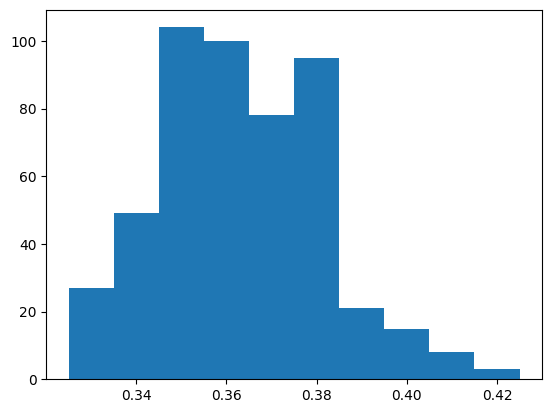

In [16]:
import matplotlib.pyplot as plt
plt.hist(Phi)
np.mean(Phi), np.std(Phi)